# **데이터 선정 이유 및 문제 정의**

**2020년의 에어비앤비**는 코로나 19로 인해 가장 참혹한 위기를 겪었습니다.

그러나 **전 세계적으로 백신 접종이 확대됨**과 동시에 **각국에서 여행이 회복됨**에 따라 에어비앤비의 위기는 길지 않았고, **다시 영업 이익의 고점**을 기록하며 **'대박'**을 치게 됩니다.

위기 속에서도 에어비앤비가 **승승장구** 할 수 있었던 비결은 무엇일까요?

기존의 에어비앤비는 누구나 선망하는 대도시 여행과 숙소만을 전면에 내세웠다면 이제는 코로나 19 시대에 맞춰 이용자가 사는 **지역 인근의 숙소또한 소개**하는 데 초점을 맞춘 것이지요.

또한 **재택근무 등이 일상화되며 다른 지역에서 장기간 투숙하는 방식**도 주목받고 있습니다.

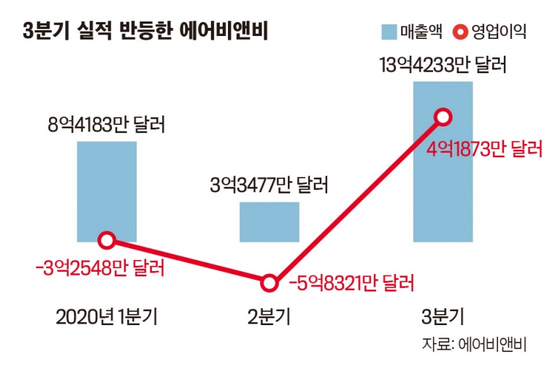

사람들이 원하는 것은 대중 여행이 아니라 **의미 있는 여행**이며, **위드 코로나**가 시작된 만큼 사람들은 다시 여행을 준비하기 시작했습니다.

**현 시점에서 '여행'**이라는 키워드가 화제가 되고있는 만큼 **에어비앤비**에서 제공하는 데이터를 이용해 **숙박 가격을 예측** (회귀)하는 모델을 만들어보겠습니다.

# **데이터를 이용한 가설 및 평가지표, 베이스라인 선택**

# **평가지표** (주요 키워드)




**Baseline은** **price의 평균값**을 사용 

**MAE (Mean absolute error)** : 평균 절대 오차

실제 값과 예측값의 차이를 절댓값으로 변환해 평균한 것

값이 0에 가까울 수록 성능이 높다고 할 수 있다.

**예를 들어,** 기온을 예측하는 **모델의 MAE가 5**라면 이 모델은 평균적으로 **5도 정도를 잘못 예측**한다고 생각하면 된다.

**R2 (R- squared)**: 결정 계수

실제 값의 분산 대비 예측 값의 분산 비율

즉 회귀 모델이 얼마나 '설명력'이 있는가
1에 가까울 수록 설명력이 높다고 할 수 있다.

# **라이브러리 설치**

In [3]:
!pip install --upgrade category_encoders
!pip install pdpbox
!pip install shap
!pip install graphviz
!pip install eli5

     |████████████████████████████████| 34.0 MB 143 kB/s 
     |████████████████████████████████| 13.1 MB 60.1 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=b6844947c7eac23e4a435ebb1cfeb2190378074afc3403e5ac6ca681c0af124e
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 564 kB 5.7 MB/s 
     |████████████████████████████████| 106 kB 4.8 MB/s 


In [64]:
import pandas as pd
import numpy as np
import warnings
import sklearn
import xgboost
import shap
import eli5

import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.metrics import mean_absolute_error
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.model_selection import train_test_split
from eli5.sklearn import PermutationImportance

from category_encoders import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
warnings.filterwarnings(action='ignore')

# **EDA와 데이터 전처리**

In [5]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
df = pd.read_csv('/content/drive/MyDrive/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [7]:
df.shape

(48895, 16)

In [8]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [9]:
pd.set_option('display.max_colwidth', 0)
df[['neighbourhood_group','neighbourhood','room_type']].agg(['unique']).transpose()
#데이터 내부 확인

,unique
neighbourhood_group,"[Brooklyn, Manhattan, Queens, Staten Island, Bronx]"
neighbourhood,"[Kensington, Midtown, Harlem, Clinton Hill, East Harlem, Murray Hill, Bedford-Stuyvesant, Hell's Kitchen, Upper West Side, Chinatown, South Slope, West Village, Williamsburg, Fort Greene, Chelsea, Crown Heights, Park Slope, Windsor Terrace, Inwood, East Village, Greenpoint, Bushwick, Flatbush, Lower East Side, Prospect-Lefferts Gardens, Long Island City, Kips Bay, SoHo, Upper East Side, Prospect Heights, Washington Heights, Woodside, Brooklyn Heights, Carroll Gardens, Gowanus, Flatlands, Cobble Hill, Flushing, Boerum Hill, Sunnyside, DUMBO, St. George, Highbridge, Financial District, Ridgewood, Morningside Heights, Jamaica, Middle Village, NoHo, Ditmars Steinway, Flatiron District, Roosevelt Island, Greenwich Village, Little Italy, East Flatbush, Tompkinsville, Astoria, Clason Point, Eastchester, Kingsbridge, Two Bridges, Queens Village, Rockaway Beach, Forest Hills, Nolita, Woodlawn, University Heights, Gravesend, Gramercy, Allerton, East New York, Theater District, Concourse Village, Sheepshead Bay, Emerson Hill, Fort Hamilton, Bensonhurst, Tribeca, Shore Acres, Sunset Park, Concourse, Elmhurst, Brighton Beach, Jackson Heights, Cypress Hills, St. Albans, Arrochar, Rego Park, Wakefield, Clifton, Bay Ridge, Graniteville, Spuyten Duyvil, Stapleton, Briarwood, Ozone Park, Columbia St, Vinegar Hill, Mott Haven, Longwood, ...]"
room_type,"[Private room, Entire home/apt, Shared room]"


In [10]:
pd.DataFrame(df.isnull().sum(), columns=["결측치 개수"]) #결측치 확인

,결측치 개수
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [11]:
df.drop(['id','name','host_id','host_name','last_review'], axis=1, inplace=True)
df = df.dropna()
df = df.drop_duplicates()
df.head() #분석에 불필요한 column과 결측치 및 중복값 제거

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
5,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129


# **머신러닝 전 데이터 이해를 위한 시각화**

먼저 시각화 해볼법한 column을 찾아보겠습니다.

In [12]:
df.neighbourhood_group.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [13]:
df.neighbourhood.unique()

array(['Kensington', 'Midtown', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Harlem', 'Greenpoint', 'Bushwick', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Flatbush', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [14]:
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

**방 타입**과 **지역** 정도가 **시각화**했을 때 유의미할 것으로 보입니다.

Text(0.5, 1.0, 'NYC airbnb room type')

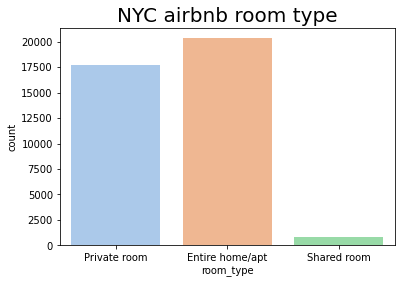

In [15]:
sns.countplot(df['room_type'], palette='pastel')
fig = plt.gcf()
fig.set_size = (20, 10)
plt.title('NYC airbnb room type', size = 20)

**Private room**과 **Entire home/apt 타입의 방이 대다수**임을 확인했습니다.

Text(0.5, 1.0, 'NYC neighbourhood')

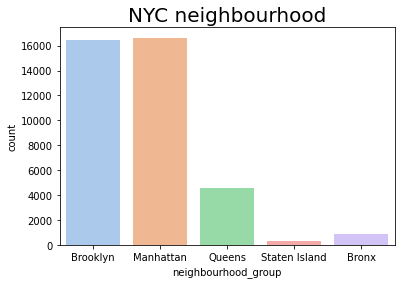

In [16]:
sns.countplot(df['neighbourhood_group'],palette='pastel')
fig = plt.gcf()
fig.set_size = (20, 10)
plt.title('NYC neighbourhood', size = 20)

**브루클린 지역**과 **맨해튼 지역**에 **등록 되어 있는 방**이 상대적으로 **많이 있음**을 알 수 있습니다.

Text(0.5, 1.0, 'NYC neighbourhood price')

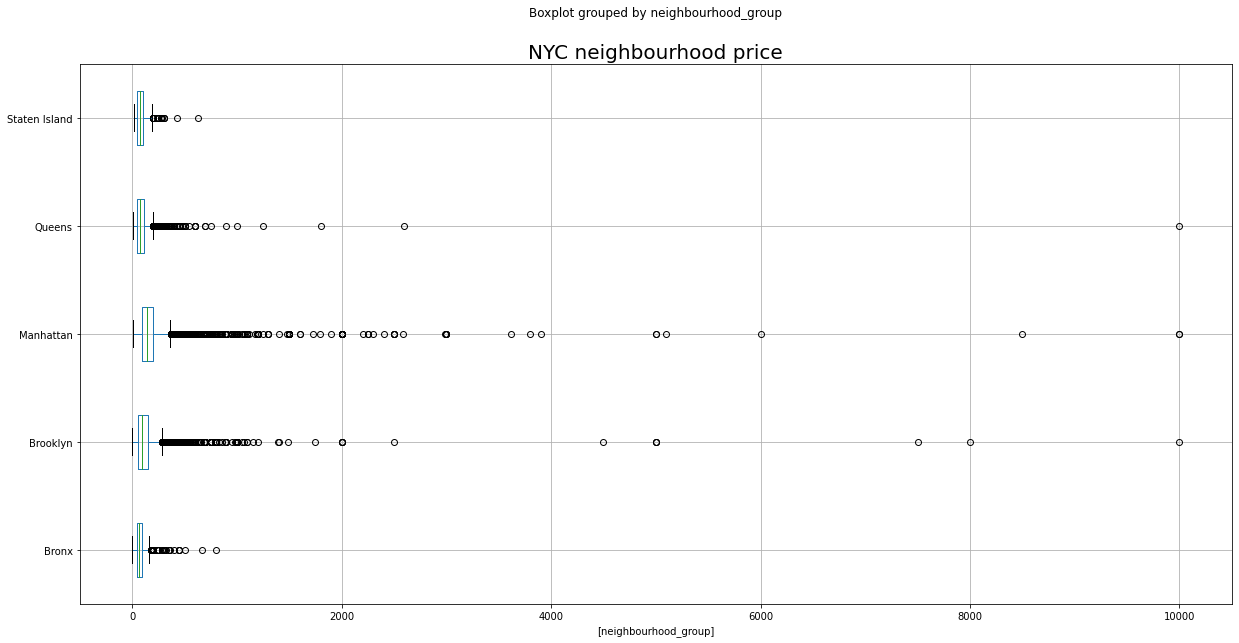

In [18]:
price = df[['neighbourhood_group', 'price']]
price[['neighbourhood_group','price']].boxplot(by = 'neighbourhood_group', figsize=(20, 10), vert=False)
plt.title('NYC neighbourhood price', size = 20)

**가격** 관련 데이터에 **outlier**가 어느정도 분포되어있음을 알 수 있습니다. 추후 처리가 필요해보입니다.

Text(0.5, 1.0, "NYC neighbourhood rooms' available days in a year")

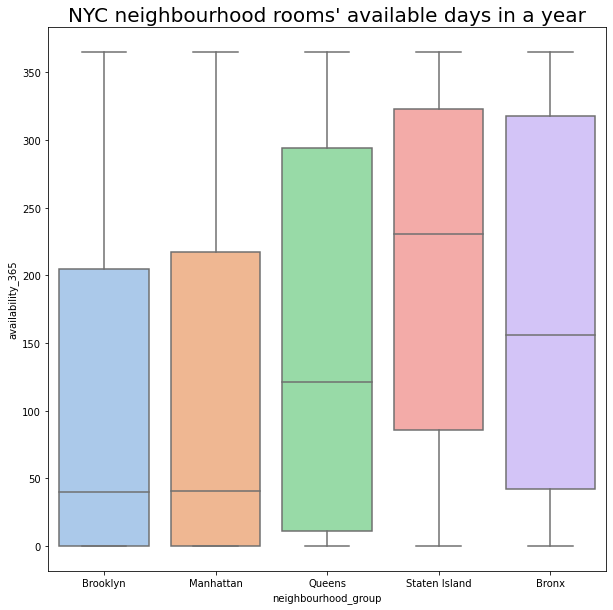

In [19]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data= df, x= 'neighbourhood_group', y='availability_365', palette='pastel')
plt.title("NYC neighbourhood rooms' available days in a year", size = 20)

**availability_365** column은 **1년 중 예약이 가능한 날짜를 1~365 사이 값**으로 나타낸 지표로써, 

**브루클린** 지역과 **맨해튼** 지역이 상대적으로 **예약 날짜가 많이 차 있는것**을 확인할 수 있습니다.

(8.5, -0.5)

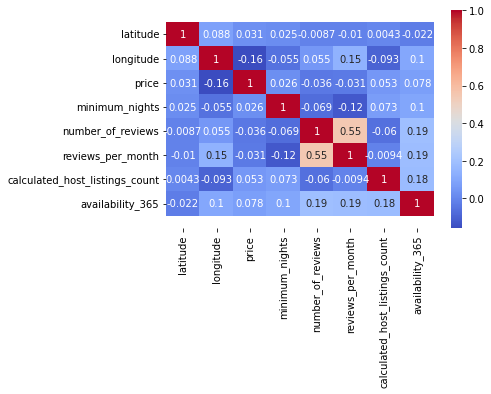

<Figure size 720x720 with 0 Axes>

In [21]:
heat_nyc = sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.figure(figsize=(10,10))
heat_nyc.get_ylim()
bottom, top = heat_nyc.get_ylim()
heat_nyc.set_ylim(bottom + 0.5, top - 0.5)

각 **column들간의 상관관계**를 확인해 보았습니다.

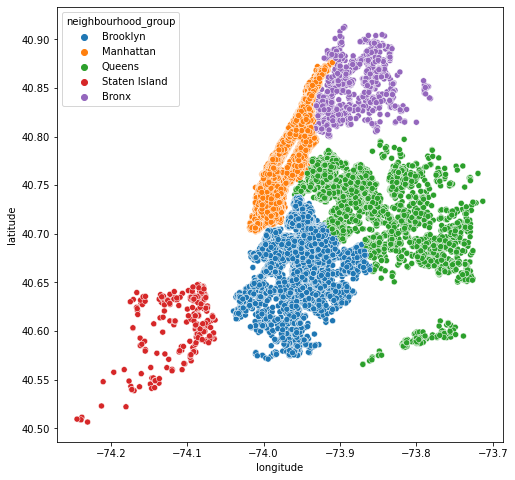

In [22]:
plt.figure(figsize=(8, 8))
sns.scatterplot(df.longitude, df.latitude, hue = df.neighbourhood_group)

**실제로 경도 위도가 잘 반영되었는지 확인해 보았습니다**

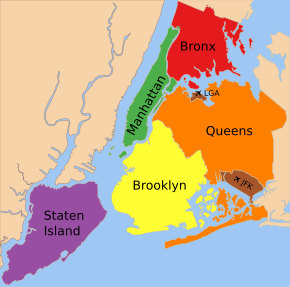

# **학습 시작**

In [ ]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
5,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129


In [23]:
df.drop(['latitude','longitude'], axis = 1, inplace=True)
#위도와 경도를 제거하는 이유는 앞 column들인 neighbourhood_group 과 neighbourhood로 충분히 정보가 설명되기 때문입니다.
df.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,0.59,1,129


# **Baseline 생성**

타겟인 price의 평균을 기준 모델로 사용하겠습니다.

In [24]:
df['price'].mean()

142.317946605566

In [25]:
def encoder(df):
    for column in df.columns[df.columns.isin(['neighbourhood_group', 'neighbourhood','room_type'])]:
      df[column] = df[column].factorize()[0]
    return df
df1 = encoder(df) #범주형 변수들을 factorize 함수를 활용해 숫자형 변수로  변경

In [26]:
target = 'price'

X = df1.drop(columns='price', axis = 1)
y = df1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (31074, 8)
y_train shape (31074,)
X_test shape (7769, 8)
y_test shape (7769,)


# **다중선형회귀 학습**

In [27]:
model = LinearRegression()

# 모델 fit
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')
print(r2_score(y_train, y_pred))

훈련 에러: 65.92
0.0797560463879704


In [28]:
# 테스트 데이터에 적용
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')
print(r2_score(y_test, y_pred))

테스트 에러: 68.73
0.047116642992913405


회귀 모델의 **설명력이 오히려 더 떨어졌습니다.**

성능이 더 낮아진 것으로 보아 이전에 발견한 **숙소 가격 관련 outlier들이 영향**을 끼치고 있는게 아닌가 싶어서 확인해 보겠습니다.

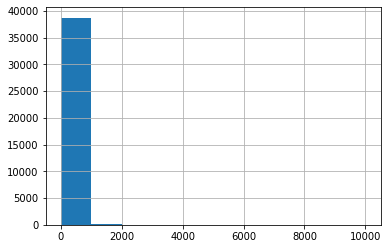

In [29]:
df1['price'].hist()

로그화 과정을 거쳐 **정규 분포 형태로 변경**하겠습니다.

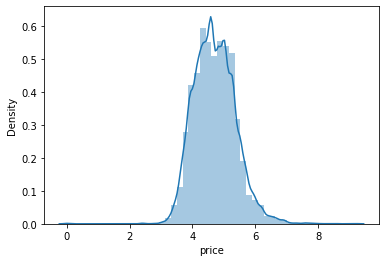

In [31]:
price1 = np.log1p(df1['price'])
sns.distplot(price1)

In [32]:
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state = 2)

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_train)
y_train_og = np.expm1(y_train)
y_pred_og = np.expm1(y_pred)

mae = mean_absolute_error(y_train_og, y_pred_og)
r2 = r2_score(y_train_og, y_pred_og)

print(f'훈련 에러: {mae:.2f}')
print(r2)

훈련 에러: 61.32
0.04291211238115855


In [34]:
y_pred = model.predict(X_test)
y_test_og = np.expm1(y_test)
y_pred_og = np.expm1(y_pred)



mae = mean_absolute_error(y_test_og, y_pred_og)
r2 = r2_score(y_test_og, y_pred_og)

print(f'테스트 에러: {mae:.2f}')
print(r2)

테스트 에러: 63.77
0.024171443408234627


**성능이 되려 저하**됐습니다.

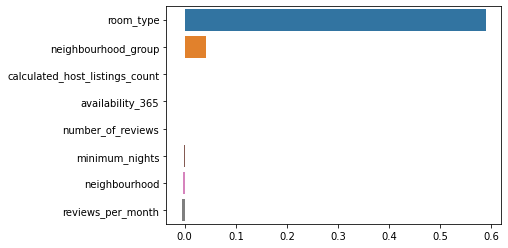

In [35]:
coef = pd.Series(model.coef_, index=X.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x= coef_sort.values, y= coef_sort.index)

**회귀 계수를 확인해 보니 room_type의 영향을 지나치게 많이 받고 있음**을 확인했습니다.

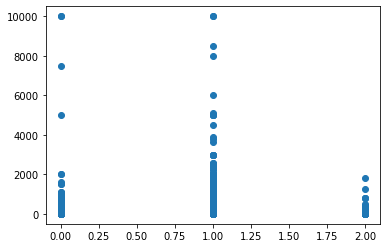

In [36]:
plt.scatter(x= df1['room_type'], y=df1['price'])
plt.show()

**outlier 들을 제거**해 보겠습니다

In [37]:
df1['room_type'].unique() # factorize()를 통해 room type이 숫자형 데이터로 변경됨

array([0, 1, 2])

In [38]:
room_0 = df1['room_type'] == 0
price_over = df1['price'] > 4000
outlier = df1[room_0 & price_over].index

df1.drop(outlier, axis=0, inplace = True)

# 0 타입 숙소에 가격이 4000$이 넘는 경우

room_1 = df1['room_type'] == 1
price_over1 = df1['price'] > 6000
outlier1 = df1[room_1 & price_over1].index

df1.drop(outlier1, axis=0, inplace = True)

# 1 타입 숙소에 가격이 6000$이 넘는 경우

다시 학습을 해보겠습니다.

In [39]:
target = 'price'

X = df1.drop(columns='price', axis = 1)
y = df1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)

In [40]:
model = LinearRegression()

# 모델 fit
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')
print(r2_score(y_train, y_pred))

훈련 에러: 65.24
0.11112533723872942


In [41]:
# 테스트 데이터에 적용
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')
print(r2_score(y_test, y_pred))

테스트 에러: 61.48
0.15057302371317305


**테스트 세트 기준** 

**mae**는 **68.73에서 61.48**로,


**r2**는 **0.047**에서 **0.15**로 미미하지만 **성능이 향상**되었음을 확인했습니다.

# **랜덤 포레스트 회귀 학습**

In [42]:
pipe = make_pipeline(
    RandomForestRegressor(n_jobs=-1,max_depth = 10, n_estimators=100, oob_score=True, random_state=2)
)

target = 'price'

X = df1.drop(columns='price', axis = 1)
y = df1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print(f'테스트 에러: {mae:.2f}')
print(r2_score(y_test, y_pred))

테스트 에러: 49.99
0.35618480774654915


**랜덤 포레스트**를 통한 학습 결과 

**지난 학습대비** 


**mae**는 **61.48에서 49.99**로,


**r2**는 **0.15에서 0.36**으로 **성능이 많이 향상**되었음을 확인했습니다.

# **교차검증을 랜덤 포레스트에 적용시켜보겠습니다**

In [43]:
pipe = make_pipeline(
    RandomForestRegressor(n_jobs=-1,max_depth = 10, n_estimators=100, oob_score=True, random_state=2)
)

k = 3

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [53.74814425 56.24530776 55.6961237 ]


In [46]:
print(-scores.mean(), scores.std())

55.2298585678746 1.071450349461947


# **하이퍼 파라미터 튜닝**

In [47]:
pipe = make_pipeline(
    RandomForestRegressor(random_state=2)
)

dists = {   
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [48]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.3137043762826388, 'randomforestregressor__n_estimators': 292}
MAE:  53.8271122630149


In [49]:
pipe = clf.best_estimator_

y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:,.2f}')
print(r2_score(y_test, y_pred))

테스트 에러: 48.57
0.3844649027003406


**하이퍼파라미터 튜닝**을 통해 모델을 학습시킨 결과,

**지난 랜덤포레스트 모델 대비**

**mae**는 **49.99에서 48.57**으로,


**r2**는 **0.36에서 0.38**으로 **성능이 어느정도 향상**되었음을 확인했습니다.

# **Xgboost로 학습**

In [50]:
pipe = make_pipeline(
    XGBRegressor(n_jobs=-1, n_estimators=200, max_depth=7, learning_rate=0.2, random_state=2)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f'테스트 에러: {mae:,.2f}')
print(r2_score(y_test, y_pred))

[09:04:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
테스트 에러: 50.50
0.31201019141751074


아직 하이퍼파라미터 설정을 해주지 않았기 때문에 성능의 변동이 크게 없어보입니다.

# **Xgboost 하이퍼 파라미터 튜닝**

In [51]:
pipe = make_pipeline(
    XGBRegressor(random_state=2,
                 eval_metric = 'mae',
                 early_stopping_trounds = 30)
)

params = {
    'xgbregressor__max_depth': [5, 10, 15, 20, None],
    'xgbregressor__learning_rate': uniform(0.01, 0.2),
    'xgbregressor__subsample': uniform(0.1, 1),
    'xgbregressor__colsample_bytree': uniform(0.1, 1),
    'xgbregressor__max_features': uniform(0, 1)
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=params, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[09:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [52]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'xgbregressor__colsample_bytree': 0.5098355012721295, 'xgbregressor__learning_rate': 0.02244590650802493, 'xgbregressor__max_depth': 15, 'xgbregressor__max_features': 0.9761317067854394, 'xgbregressor__subsample': 0.6869218223335357}
MAE:  51.24333390916991


In [53]:
pipe = clf.best_estimator_

y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:,.2f}')
print(r2_score(y_test, y_pred))

테스트 에러: 46.18
0.33939125001851445


**최종 Xgboost 하이퍼파라미터 튜닝**을 통해 모델을 학습시킨 결과,

**하이퍼 파라미터를 마친 랜덤포레스트 모델 대비**

**mae**는 **48.53에서 46.18**으로, mae의 성능은 상승했으나


**r2**는 **0.38에서 0.34**으로 **회귀 모델의 설명력**은 지난 모델 대비 **약간 하락**했음을 확인했습니다.

In [54]:
y_test.mean()

136.39024076219906

#최초 학습 모델
**MAE = 68.73**

**R2 = 0.0471**

#최종 모델

**MAE = 46.18**

**R2 = 0.339**

# **머신러닝 결과 시각화**

**Test 셋**의 일부 데이터를 가지고 모델의 **예측결과**가 얼마나 좋게 나왔는지 **시각화** 해보겠습니다.

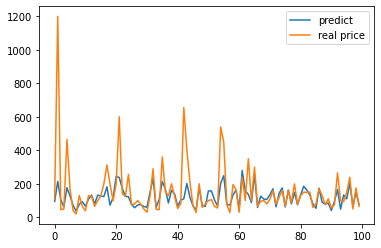

In [55]:
plt.plot(clf.predict(X_test[:100]), label="predict")
plt.plot(y_test[:100].values.reshape(-1, 1), label="real price")
plt.legend()

**outlier** 성격을 띄는 데이터를 제외하고 대체적으로 비슷한 결과를 보였습니다.

**pdp plot**을 통해 **데이터 내 각 변수와 숙소 가격(target)**에 어떤 영향을 미치는 지 살펴보겠습니다.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


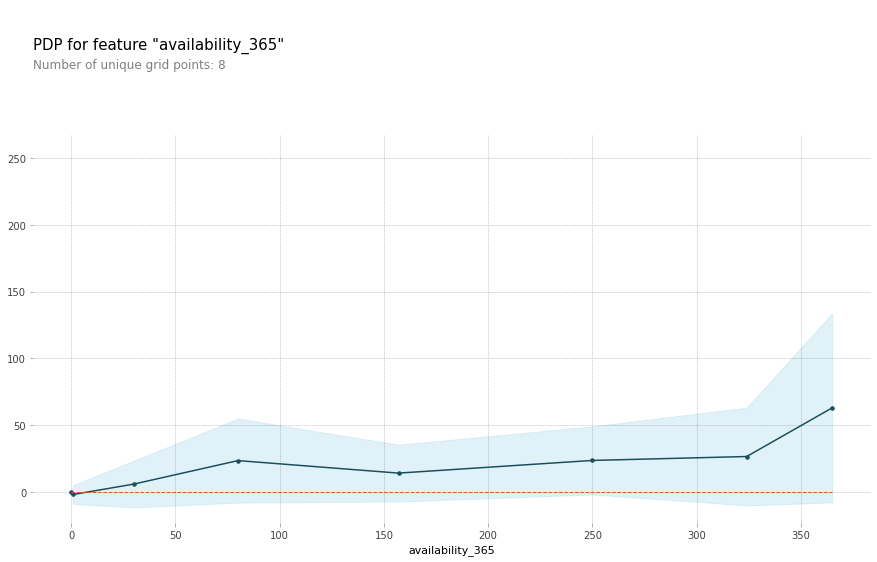

In [56]:
feature = 'availability_365'

isolated = pdp_isolate(
    model=clf, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

**1년 중 예약이 잡혀있지 않은 날이 많은 방 일수록 가격이 올라간다.**

(비싼 방일수록 찾는 사람이 적다라고 해석해도 될까?)

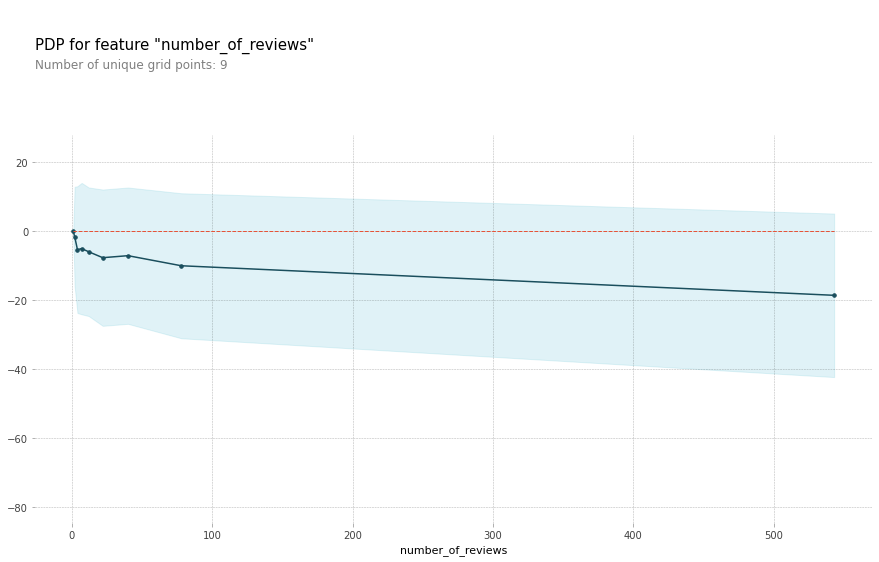

In [57]:
feature = 'number_of_reviews'

isolated = pdp_isolate(
    model=clf, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

**리뷰가 많은 방 일수록 가격이 낮아지는 것을 확인할 수 있다.**

(대다수의 사람들이 저렴한 방을 이용하는 것을 선호하고, 그에 따라 자연스럽게 리뷰량도 누적되기 때문에 보이는 현상이라 해석해도 될까?)

In [58]:
model = xgboost.XGBRegressor(colsample_bytree=0.9251, learning_rate=0.016, max_depth=15, max_features= 0.1087, subsample=0.5104)

model.fit(X_test, y_test)

[09:12:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.9251, learning_rate=0.016, max_depth=15,
             max_features=0.1087, subsample=0.5104)

In [59]:
row = X_test.iloc[[10]]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features = row)

**긍정적인 영향**을 끼친 것은 **빨간색**으로 표시, **부정적인 영향**을 끼친 것은 **파란색**으로 표시

In [60]:
shap.initjs()
shap_values = explainer.shap_values(X_test.iloc[:200])
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features = X_test.iloc[:200])

shap을 활용해 각 변수간의 관계도 확인 가능하다

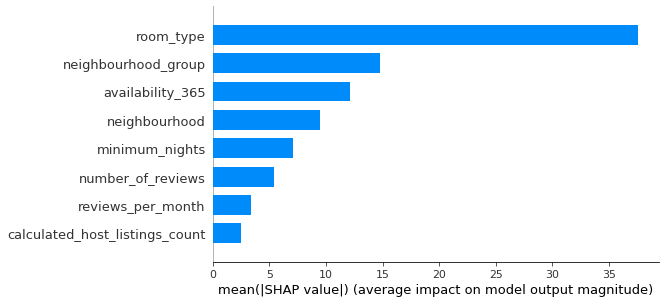

In [62]:
shap.summary_plot(shap_values, X_test.iloc[:300], plot_type="bar")

In [67]:
permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error', 
    n_iter=5,
    random_state=2
)

permuter.fit(X_test, y_test)

feature_names = X_test.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
26.9386 ± 1.1683,room_type
10.7215 ± 0.1776,neighbourhood_group
9.6928 ± 0.3754,neighbourhood
9.4743 ± 0.1444,availability_365
5.5964 ± 0.1948,minimum_nights
5.4860 ± 0.3234,reviews_per_month
4.8222 ± 0.2323,number_of_reviews
2.4994 ± 0.2075,calculated_host_listings_count


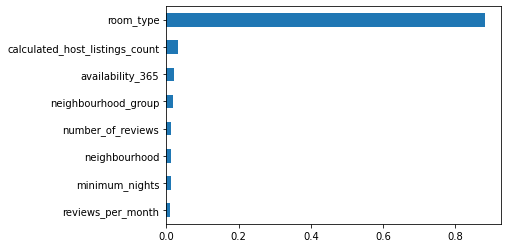

In [68]:
importances = pd.Series(model.feature_importances_, X_test.columns)
importances.sort_values().plot.barh();

**모델에서 가장 영향력이 큰 특성은 room_type임을 알 수 있다.**

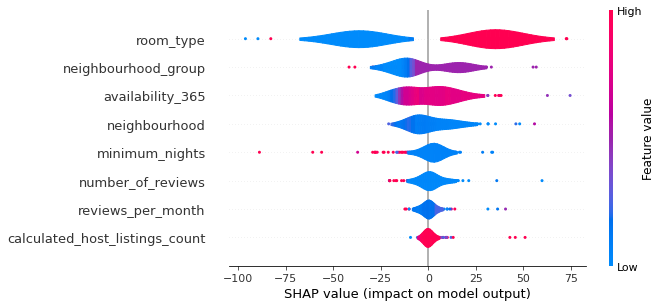

In [69]:
shap_values = explainer.shap_values(X_test.iloc[:200])
shap.summary_plot(shap_values, X_test.iloc[:200], plot_type="violin")

#아쉬웠던 점


**가격에 영향**을 주는 다른 요인들이 더 많이 포함된 데이터였다면 (예를 들어 **주변 시설물, 청결도**) **모델의 성능이 어떻게 변했을지, 또 어떤 다른 인사이트를 도출할 수 있었을지** 궁금하다.

아래와 같이 **factorize한 데이터를 토대로 shap 시각화**를 했기 때문에 **room_type이나 neighborhood 값이 지역 명이 아닌 수치형**으로 나와 어느 지역인지 직접 대조해봐야 알 수 있었던 점이 아쉽다.

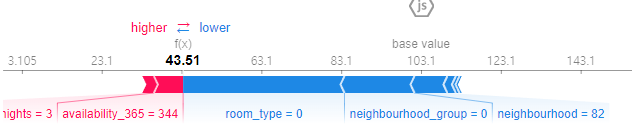

이 또한 역으로 변환하는 코드를 알아내면 해결 될 것으로 보인다. 더 공부해보자.

이후 이 데이터만을 가지고 어떻게 하면 더 좋은 성능을 얻을 수 있을지 더 알아볼 예정이다.

In [70]:
df_new = pd.read_csv('/content/drive/MyDrive/AB_NYC_2019.csv')

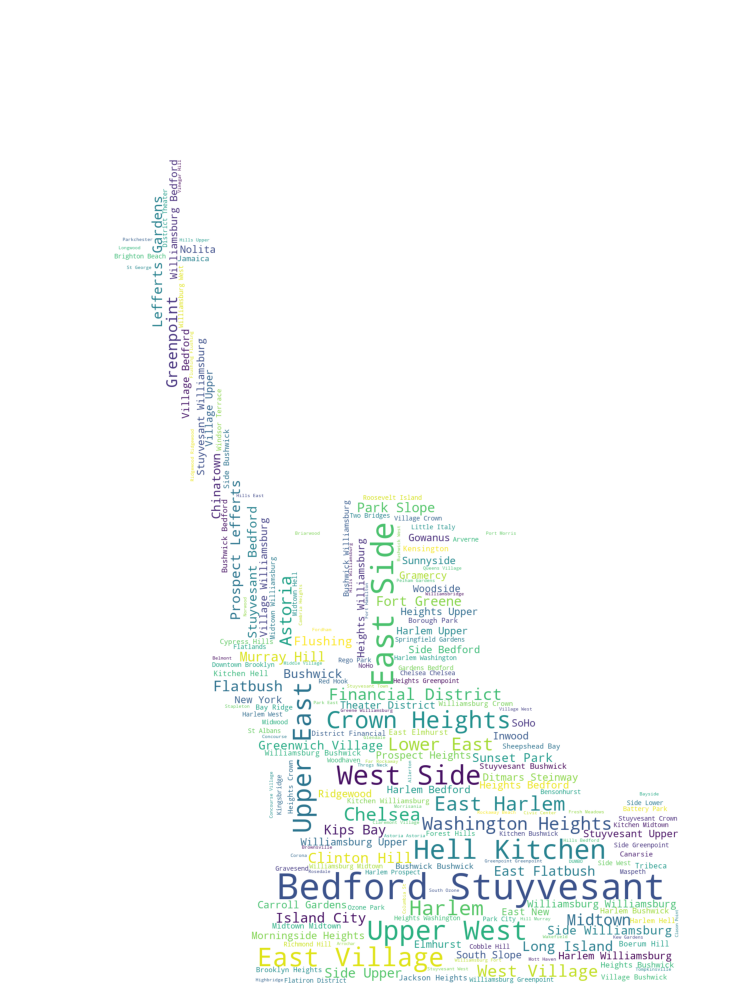

In [71]:
from wordcloud import WordCloud
from PIL import Image

mask_image = np.array(Image.open('./drive/MyDrive/nyc2.png'))
plt.subplots(figsize=(36,18))
wordcloud=WordCloud(background_color='white', mask=mask_image, width=1920, height=1080).generate(" ".join(df_new.neighbourhood))
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

# 감사합니다